# Network analysis of collaborations between artists

The main purpose of this section has been developing a network analysis of the collaborations between the top 100 artists for every 7 genres defined. With it, each user can be able to abstract useful information from the collaborations between the different top artists per genre, see which genres tend to have more collaborations between artists, see if the different artists tend to do collaborations with artists within the same genre or a different one, between others. In the end, we would also like to realize if we can try to create a small recommendation system from the tools learnt during the course.

To be able to achieve all previous statements, first, some python libraries' installations are been needed and we have also downloaded the previously obtained data from Spotify from our public repository. Moreover, we create two pandas data frames with all the information loaded from the *artists.csv*, *artists_colab.csv* and *artists_colab_singles.csv* files.



In [1]:
#Libraries installations needed
!pip install spotipy
!pip install fa2
!pip install python-louvain

In [2]:
#Clone our public repository to obtain all downloaded data
!git clone https://github.com/balbinavr/SGI_Sportify_Project.git
#rm -rf SGI_Sportify_Project/

fatal: destination path 'SGI_Sportify_Project' already exists and is not an empty directory.


In [0]:
#Import all needed libraries
import pandas as pd
import networkx as nx
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import matplotlib.patches as mpatches
from community import community_louvain
from random import choice
import warnings
warnings.filterwarnings("ignore")
import seaborn as sn
from random import random

In [0]:
#Define genres that will be used
genres = ['pop','rock','hip-hop','blues','indie','country','soul']

#Load the list of artists and their related information
artistsList = pd.read_csv('./SGI_Sportify_Project/artists.csv', encoding='utf-8')
#Load the list of collaborations between artists
colaborationsListAlbums = pd.read_csv('./SGI_Sportify_Project/artists_colab.csv', encoding='utf-8',engine='python')
colaborationsListSingles = pd.read_csv('./SGI_Sportify_Project/artists_colab_singles.csv', encoding='utf-8',engine='python')
frames = [colaborationsListAlbums,colaborationsListSingles]
#Create a unique dataframe with the information from both previous files loaded
colaborationsList = pd.concat(frames)

## Network creation (First approach)

Then, we have used the *artists.csv* , *artists_colabs.csv* and *artists_colabs_singles.csv* files to create a network of collaborations from which we will work from now on.

To better understand the data obtained, we first decided to create a *directed graph* with the following characteristics:

* Node: Artist inside the top 100 of each genre
    * Name attribute for each node
* Edge: Collaboration between artists
    * In node: Artist in which the song was obtained
    * Out node: Artist collaborator to that song
    * Edge weight: Number of times that they have collaborated
    
Networkx python library has been used to generate our desired graph. In order to create the graph correctly, we have needed to keep just the collaborations between the artists that belong to the top 100 of the 7 genres chosen.

Using the iteration, a dictionary with all genres for each artist has been created. Having this information kept will be useful for further parts of the analysis, as one artist can belong to several different genres.

In [0]:
#Create empty directional graph
G = nx.DiGraph()

In [0]:
#Create a dictionary with all collaborations for each artist (Key:Artist, Values:List of artists and number of collaborations done)
artistsColabDict = dict()
#Create a dictionary with all genres for each artist (Key:Artist, Values:List of genres per artist)
genre_dict = dict()
names_dict = dict()

#Iterate for the list of artists
for artist in artistsList.iterrows():
    
    #Fill genre_dict
    if artist[1]['Artist_id'] in genre_dict:
      genresArtist = genre_dict[artist[1]['Artist_id']]
      genresArtist.append(artist[1]['Genre'])
      genre_dict[artist[1]['Artist_id']] = genresArtist
    else:
      genre_dict[artist[1]['Artist_id']] = [artist[1]['Genre']]
      
    #Create a node and the attributes for each artist
    G.add_node(artist[1]['Artist_id'])
    nx.set_node_attributes(G, {artist[1]['Artist_id']: {"Genre": artist[1]['Genre'], "Name": artist[1]['Artist']}})
    
    names_dict[artist[1]['Artist_id']] = artist[1]['Artist'].replace("$","")
  
    #Keep the information about the collaboration created inside the artistsColabDict
    #If the information for that artist is already on the dict we skip it
    if (artistsColabDict.get(artist[1]['Artist_id']) is None):
      #Create the collaborationsList
      #Find all the artists that have collaborated with current artist
      #And count the number of collaborations done with each artist
      artistsColabs = colaborationsList[colaborationsList['Artist_id'] == artist[1]['Artist_id']]
      artistsColabs = artistsColabs[artistsColabs['ArtistColab_id'].isin(artistsList.Artist_id.values)]
      uniqueColabs = Counter(artistsColabs.ArtistColab_id.values)
      #print(uniqueColabs)
      
      artistsColabDict[artist[1]['Artist_id']] = uniqueColabs

      #Add all colaborations to the network
      for artistColab in uniqueColabs.items():
          #Create the link and set the number of collaborations to that member as the weight of the relation
          G.add_edge(artist[1]['Artist_id'], artistColab[0], weight=artistColab[1])

Once the network is created, the first analysis on it has been performed. As can be seen, a network of 609 nodes and 2827 edges has been created.  Exactly 158 of this nodes are isolated.

From this information retrieved, it can be realized that there are 91 artists of our dataset that belong to two or more genres. That is why the number of artists has been reduced. 

Furthermore, we can say that the **25%** of the artists of our network do not have collaborations and the mean of the number of artists with which an artist has collaborated is **4,6**.

In [7]:
#Check useful information of the netwotk created
print("Number of nodes", len(G.nodes))
print("Number of edges", len(G.edges))
print("Number of isolated nodes", len(list(nx.isolates(G))))

Number of nodes 609
Number of edges 2827
Number of isolated nodes 158


Then, we wanted to analyze the isolated nodes of our graph. Our main objective of this analysis was to see how many artists per genre had no collaborations, to be able to determine the distribution of collaborations per genre.

To achieve it, the genres of the isolated nodes were retrieved and using a Bar chart plot the information was displayed.

In [0]:
#Check genres of the isolated nodes
#Plot in a histogram
def obtainGenresOfIsolatedNodes(G):
  isolatedGenres = dict()
  #Initialize dictionary of isolated nodes
  for genre in genres:
    isolatedGenres[genre] = 0
  #Fill information with isolated nodes of the network created
  for node in list(nx.isolates(G)):
    for gen in genre_dict[node]:
        isolatedGenres[gen] += 1
  return isolatedGenres

In [0]:
def plotBarChartFromDict(infoDict):
  #Order desc the information of the given dict
  orderedinfoDict = sorted(infoDict.items(), key=lambda kv: -kv[1])
  #Obtain list of keys
  objects = [el[0] for el in orderedinfoDict]
  y_pos = np.arange(len(objects))
  #Obtain list of values
  performance = [el[1] for el in orderedinfoDict]
  
  #Plot bar chart
  plt.bar(y_pos, performance, align='center', alpha=0.5)
  plt.xticks(y_pos, objects)
  plt.ylabel('# isolated nodes')
  plt.title('Isolated nodes per genre')
  plt.show()

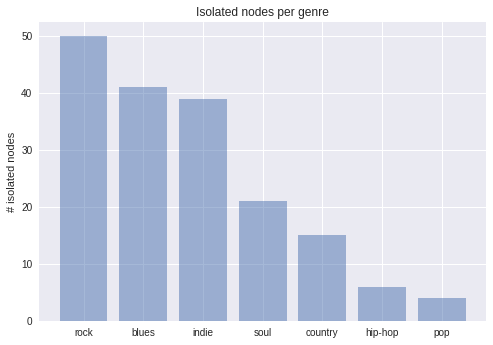

In [10]:
#Plot chart of isolated nodes per genre
isolatedGenres = obtainGenresOfIsolatedNodes(G)
plotBarChartFromDict(isolatedGenres)

With the information retrieved, we can say that the genre with more artists without collaborations is *rock*. Fifty artists of the rock genre have no collaborations, which means that 50% of the artists of genre rock do not collaborate with other artists. This measure is quite significant to determine that rock artists tend to just perform their own music.

Rock genre is followed by blues and indie, which have around 40 isolated artists. While, on the other side, pop and hip-hop are the genres with less non-connected nodes. It means that around 95% of the artists of both, pop and hip-hop genre have collaborated with at least one of the other top artists.


Afterwards, we wanted to analyze the connections created between nodes to confirm that the created graph made sense from the data used. As we created a directed graph, first, both in and out degrees, with both weight and without it, have been analyzed.

In [0]:
def calculateInAndOutgoingDegree(G, weightTrue=False): 
    inoutgoingDegreeDict = dict()
    count = 0
    countIn = 0
    countOut = 0
    for node in G.nodes:
      if(weightTrue):
        inD = G.in_degree(node, weight='weight')
        outD = G.out_degree(node, weight='weight')
      else:
        inD = G.in_degree(node)
        outD = G.out_degree(node)
      pred = list(G.predecessors(node))
      succ = list(G.successors(node))
      inoutgoingDegreeDict[node] = [[inD,pred],[outD,succ]]
      if (inD == outD):
        count+=1
      elif (inD > outD):
        countIn +=1
      elif (outD > inD):
        countOut +=1
    return count, countIn, countOut, inoutgoingDegreeDict

In [12]:
#Analysis of in and out degrees without analysing the weight of the connections
counter, counterIn, counterOut, inoutgoingDegreeDict = calculateInAndOutgoingDegree(G, False)
print("Number of artists that have the same in and out degree: ", counter)
print("Number of artists that have bigger out than in degree: ", counterOut)
print("Number of artists that have bigger in than out degree: ", counterIn)

#Show Ed Sheran example
example = inoutgoingDegreeDict["6eUKZXaKkcviH0Ku9w2n3V"]
print("Ed Sheran example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Different nodes - ", len(set(list(G.predecessors("6eUKZXaKkcviH0Ku9w2n3V"))+list(G.successors("6eUKZXaKkcviH0Ku9w2n3V")))))

#Show Drake example
example = inoutgoingDegreeDict["3TVXtAsR1Inumwj472S9r4"]
print("Drake example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Different nodes - ", len(set(list(G.predecessors("3TVXtAsR1Inumwj472S9r4"))+list(G.successors("3TVXtAsR1Inumwj472S9r4")))))

#Show Hillsong United example
example = inoutgoingDegreeDict["74cb3MG0x0BOnYNW1uXYnM"]
print("Hillsong United example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Different nodes - ", len(set(list(G.predecessors("74cb3MG0x0BOnYNW1uXYnM"))+list(G.successors("74cb3MG0x0BOnYNW1uXYnM")))))

Number of artists that have the same in and out degree:  224
Number of artists that have bigger out than in degree:  179
Number of artists that have bigger in than out degree:  206
Ed Sheran example: 
	 In Degree -  4
	 Out Degree -  2
	 Different nodes -  5
Drake example: 
	 In Degree -  39
	 Out Degree -  27
	 Different nodes -  47
Hillsong United example: 
	 In Degree -  1
	 Out Degree -  1
	 Different nodes -  1


In [13]:
#Analysis of in and out degrees with analysis of the weight of the connections
counter, counterIn, counterOut, inoutgoingDegreeDict = calculateInAndOutgoingDegree(G, True)
#Show Ed Sheran example
example = inoutgoingDegreeDict["6eUKZXaKkcviH0Ku9w2n3V"]
print("Ed Sheran example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Total - ", example[0][0]+example[1][0])

#Show Drake example
example = inoutgoingDegreeDict["3TVXtAsR1Inumwj472S9r4"]
print("Drake example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Total - ", example[0][0]+example[1][0])

#Show Hillsong United example
example = inoutgoingDegreeDict["74cb3MG0x0BOnYNW1uXYnM"]
print("Hillsong United example: ")
print("\t In Degree - ", example[0][0])
print("\t Out Degree - ", example[1][0])
print("\t Total - ", example[0][0]+example[1][0])

Ed Sheran example: 
	 In Degree -  149
	 Out Degree -  2
	 Total -  151
Drake example: 
	 In Degree -  8253
	 Out Degree -  9510
	 Total -  17763
Hillsong United example: 
	 In Degree -  14843
	 Out Degree -  14843
	 Total -  29686


Thanks to the network created, we wanted to analyze if the data obtained from Spotify was completed and how it was structured. More concretely, we were wondering if one artist that collaborated on a song with another artist, then that song was retrieved on the list songs of both artists or not. More concretely, we wanted to check if the data of all songs were repeated or, otherwise, more preprocess related to the songs of each artist should be done. 

With the results retrieved, we realized that just 224 nodes out of 609 had the same number of in and out degrees. And we also realized that the predecessors and successors nodes were not even the same ones.

Taking it into account, we figured out that Spotify API did not return a complete list of artists per song so we should put more focus on the creation of our network to try to avoid to count one song multiple times on the collaboration of the songs. Having found this format on the saved information, we had a deep look at the information saved and we decided to change our approach to the creation of the collaborations network. 

## Network creation (Second approach)

We thought that it was better to create an *undirected graph* with the following characteristics:

* Node: Artist inside the top 100 of each 7 genres
    * Name attribute for each node
* Edge: Collaboration between artists
    * Edge weight: Number of times that they have collaborated in different songs

To be able to achieve it and with other considerations found on the data downloaded, the following preprocess to the data was needed to finally create the network of collaborations.

*  Delete all detected self-collaborations that are created due to typos.

*  Include just the collaborations between the top 100 artists of all genres defined.

*  Do not include duplicated songs, as we detected that there are songs duplicated with different id's.

So, as we have realized that the directed graph may not be the best solution for representing our dataset, we have created instead an undirected graph by taking into account the title of the songs to avoid the replicated ones. This way, we are avoiding the duplicated songs as we realized that Spotify give different unique identifiers to the same songs that belong to different country markets. So, avoiding the duplicated songs by title, the information represented on our network will be more accurate because we made sure that each song with more than one artist was just added once in our network.

In [0]:
#Delete self-collaborations due to typos
colaborationsListAlbums = colaborationsListAlbums[colaborationsListAlbums['Artist_id']!=colaborationsListAlbums['ArtistColab_id']]
colaborationsListSingles = colaborationsListSingles[colaborationsListSingles['Artist_id']!=colaborationsListSingles['ArtistColab_id']]
frames = [colaborationsListAlbums,colaborationsListSingles]
colaborationsList = pd.concat(frames)

In [0]:
# Define an empty undirected graph
GU = nx.Graph()

In [0]:
#Delete duplicated songs by title
def deleteDuplicatedSongs(artistsColabs):
  df = artistsColabs.drop_duplicates(['Artist_id','ArtistColab_id','Song'])
  return df

In [0]:
#Create a dictionary with all collaborations for each artist (Key:Artist, Values:List of artists and number of collaborations done)
artistsColabDict = dict()
#Create a dictionary of songs per artist (Key:Artist, Values:List of songs)
artistsSongs = dict()

#Iterate for the list of artists
for artist in artistsList.iterrows():
      
    #Create a node and the attributes for each artist
    GU.add_node(artist[1]['Artist_id'])
    nx.set_node_attributes(GU, {artist[1]['Artist_id']: {"Name": artist[1]['Artist']}})
  
    #Keep the information about the collaboration created inside the artistsColabDict
    #If the information for that artist is already on the dict we skip it
    if (artistsColabDict.get(artist[1]['Artist_id']) is None):
      #Create the collaborationsList
      #Find all the artists that have collaborated with current artist
      #And count the number of collaborations done with each artist
      artistsColabs = colaborationsList[colaborationsList['Artist_id'] == artist[1]['Artist_id']]
      artistsColabs = artistsColabs[artistsColabs['ArtistColab_id'].isin(artistsList.Artist_id.values)]
      artistsColab = colaborationsList[colaborationsList['ArtistColab_id'] == artist[1]['Artist_id']]

      #Delete duplicated songs from both dataframes
      artistsColabs = deleteDuplicatedSongs(artistsColabs)
      artistsColab = deleteDuplicatedSongs(artistsColab)

      if (len(artistsColab)>0 and len(artistsColabs)>0):
        #Take the list of unique values from each dataframe
        songsColab = artistsColab.Song.unique()
        songsColabs = artistsColabs.Song.unique()
        #Create a unique list of songs from both lists of colaborations
        songs = np.unique(np.concatenate([songsColab,songsColabs]))
        artistsSongs[artist[1]['Artist_id']] = list(songs)
        #Take just the songs that are not included on the other dataframe
        artistsColabs = artistsColabs[~artistsColabs["Song"].isin(artistsColab.Song.values)]
        #Join both dataframes
        frames = [artistsColabs.ArtistColab_id, artistsColab.Artist_id]
        artistsColabConcate = pd.concat(frames)
      elif(len(artistsColab)>0):
        #Take the list of unique songs
        artistsSongs[artist[1]['Artist_id']] = list(artistsColab.Song.unique())
        artistsColabConcate = artistsColab.Artist_id
      elif(len(artistsColabs)>0):
        #Take the list of unique songs
        artistsSongs[artist[1]['Artist_id']] = list(artistsColabs.Song.unique())
        artistsColabConcate = artistsColabs.ArtistColab_id
      else:
        #Create an empty list
        artistsSongs[artist[1]['Artist_id']] = []
        artistsColabConcate = pd.DataFrame()
      #Count the number of collaborations for each other artist
      uniqueColabs = Counter(artistsColabConcate.values)
      #Add the information to the artistsColabDict
      artistsColabDict[artist[1]['Artist_id']] = uniqueColabs

      #Add all collaborations to the network
      for artistColab in uniqueColabs.items():
          #Create the link and set the number of collaborations to that member as the weight of the relation
          GU.add_edge(artist[1]['Artist_id'], artistColab[0], weight=artistColab[1])

In [18]:
#Check useful information of the netwotk created
print("Number of nodes", len(GU.nodes))
print("Number of edges", len(GU.edges))
print("Number of isolated nodes", len(list(nx.isolates(GU))))

Number of nodes 609
Number of edges 2163
Number of isolated nodes 160


Once the new network is created, it can be seen that the network contains again 609 nodes. But now the number of edges has been reduced to 2163 because the newly created graph is undirected and then, it just exists one unique edge between two nodes. The number of isolated nodes has been increased to 160 due to the elimination of the self-collaborations due to type.

So, we can say again that the **26,2%** of the artists of our network do not have collaborations and the mean of the number of artists with which an artist has collaborated is **3,5**.

Then, we just check again the isolated nodes per genre using a bar chart plot.

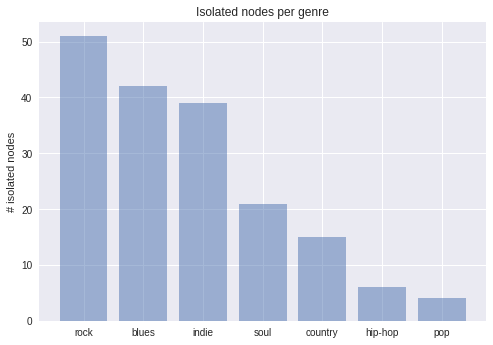

In [19]:
#Plot chart of isolated nodes per genre
isolatedGenres = obtainGenresOfIsolatedNodes(GU)
plotBarChartFromDict(isolatedGenres)
#Same as before but just to check

With the displayed plot, we can see that the two new isolated artists belong to the rock genre. During the next section, we will provide more information about one of these two artists, by giving evidence of the differences created.

Furthermore, we wanted to also analyze again, the connections created between nodes. As now we have created an undirected graph, just the degree can be analyzed. The general degree and the weighted degree have been retrieved for two artists examples.

In [0]:
#Obtains the degree and the neighbours for all nodes
def calculateDegree(GU, weightTrue = False): 
    degreeDict = dict()
    count = 0
    for node in GU.nodes:
      if (weightTrue):
        deg = GU.degree(node, weight='weight')
      else:
        deg = GU.degree(node)
      neig = list(GU.neighbors(node))
      degreeDict[node] = [deg,neig]
    return count, degreeDict

In [21]:
#Now the number of colabs are checked
count, degreeDict = calculateDegree(GU, True)

#Show Ed Sheran example
example = degreeDict["6eUKZXaKkcviH0Ku9w2n3V"]
print("Ed Sheran example: ")
print("\t Degree - ", example[0])
print("\t Neigh - ", len(example[1]))

#Show Drake example
example = degreeDict["3TVXtAsR1Inumwj472S9r4"]
print("Drake example: ")
print("\t Degree - ", example[0])
print("\t Neigh - ", len(example[1]))

#Show Hillsong United example
example = degreeDict["74cb3MG0x0BOnYNW1uXYnM"]
print("Hillsong United example: ")
print("\t Degree - ", example[0])
print("\t Neigh - ", len(example[1]))

Ed Sheran example: 
	 Degree -  9
	 Neigh -  5
Drake example: 
	 Degree -  170
	 Neigh -  47
Hillsong United example: 
	 Degree -  0
	 Neigh -  0


With the results retrieved, we can see that the number of neighbors and the number of weighted nodes is not the same one. Moreover, comparing the results with the ones obtained before, it can be realized that the number of collaborations that each artist has, has decreased considerably. But the number of distinct neighbors remains the same.

Then, after checking the information contained on the files used to upload the data, we realized that Spotify API retrieved quite a lot of repeated songs for each artist. So the filter that we added during the creation of our network was really needed to do not include repeated collaborations. Furthermore, we found an interesting example for the self-collaborations removed. More concretely, we realized that the group *Hillsong United* had many self-collaborations as Spotify API retrieved sometimes their name with different capital letters (e.g. Hillsong UNITED instead of Hillsong United). So we can see that in our current network that *Hillsong United* is an isolated node, as it is not connected to any other node, while before it had one connection and 14843 collaborations assigned.

So we believe that at this point, we have been able to create a network which represents the collaborations between the different artists but we want to plot the network created to see if we can extract more information from it.

## Network analysis


To achieve a better visualization of the network, the NetworkX draw function has been used, complemented with the force atlas algorithm, to calculate the nodes coordinates. Several functions have been developed for the calculations of the coordinates, for the size of the nodes and for assigning the correct color according to the genre of each node.


In [0]:
#Set the parameters for the Force Atlas Algorithm
def setForceAtlasParameters():
    forceatlas2 = ForceAtlas2(
                              # Behavior alternatives
                              outboundAttractionDistribution=True,  # Dissuade hubs
                              linLogMode=False,  # NOT IMPLEMENTED
                              adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                              edgeWeightInfluence=0.1,

                              # Performance
                              jitterTolerance=250.0,  # Tolerance
                              barnesHutOptimize=False,
                              barnesHutTheta=2.0,
                              multiThreaded=False,  # NOT IMPLEMENTED

                              # Tuning
                              scalingRatio=30.0,
                              strongGravityMode=False,
                              gravity=170.0,

                              # Log
                              verbose=False)
    return forceatlas2

In [0]:
#Calculate the nodes coordinates using the Force Atlas Algorithm
def calculateCoordinatesUsingForceAtlas(G_und, forceatlas2):
    positions = forceatlas2.forceatlas2_networkx_layout(G_und, pos=None, iterations=3000)
    return positions

In [0]:
#Calculate node sizes according to the given mode
def calculateSizeOfNodes(mode,G,nodes):
    if (mode == "degrees"):
        #Set nodes' size according to their degree
        deg = nx.degree(G)
        sizes = [deg[node]*5 for node in nodes]
    if (mode == "degreesWeigth"):
        #Set nodes' size according to their degree
        deg = nx.degree(G, weight='weight')
        sizes = [deg[node]*2 for node in nodes]
    if (mode == "betweenness_centrality"):
        #Set nodes' size proportional to their betweenness centrality
        between_res = nx.betweenness_centrality(G, weight='weight')
        sizes = [between_res[node]*7000 for node in nodes]
    if (mode == "closeness_centrality"):
        #Set nodes' size proportional to their closeness centrality
        between_res = nx.closeness_centrality(G)
        sizes = [between_res[node]*300 for node in nodes]
    if (mode == "eigenvector_centrality"):
        #Set nodes' size proportional to their eigenvector centrality
        eigen_res = nx.eigenvector_centrality(G, weight='weight')
        sizes = [eigen_res[node]*3000 for node in nodes]
    return sizes

In [0]:
#Calculate node colors according to the given mode
def calculateColorsOfNodes(mode,G,nodes):
  colors = []
  if(mode == "full_graph"):
    #Set node colors according to their party (blue for democratic and red for republicans)
    for n in nodes:
      ['pop','rock','hip-hop','blues','indie','country','soul']
      if (genre_dict[n] == ['pop']):
        pop_patch = mpatches.Patch(color='#4abdac', label='Pop Nodes', facecolor = 'white')
        colors.append("#4abdac")#fresh green
      elif(genre_dict[n] == ['rock']):
        rock_patch = mpatches.Patch(color='#fc4a1a', label='Rock Nodes')
        colors.append("#fc4a1a")#vermillion red
      elif(genre_dict[n] == ['hip-hop']):
        hip_hop_patch = mpatches.Patch(color='#f7b733', label='Hip Hop Nodes')
        colors.append("#f7b733")#sunshine
      elif(genre_dict[n] == ['blues']):
        blues_patch = mpatches.Patch(color='#0375b4', label='Blues Nodes')
        colors.append("#0375b4")#starry night blue
      elif(genre_dict[n] == ['indie']):
        indie_patch = mpatches.Patch(color='#007849', label='Indie Nodes')
        colors.append("#007849")#irises green
      elif(genre_dict[n] == ['country']):
        country_patch = mpatches.Patch(color='#e37222', label='Country Nodes')
        colors.append("#e37222")#country tangerine
      elif(genre_dict[n] == ['soul']):
        soul_patch = mpatches.Patch(color='#07889b', label='Soul Nodes')
        colors.append("#07889b")#teal blue
      else:
        mixt_patch = mpatches.Patch(color='#FFFFFF', label='Mixed Nodes')
        colors.append("#FFFFFF")#teal blue
    leg = plt.legend(handles=[pop_patch, rock_patch, hip_hop_patch, blues_patch, indie_patch, country_patch, soul_patch, mixt_patch], fontsize = 15)
    for text in leg.get_texts():
        plt.setp(text, color = 'w')
  return colors

In [0]:
#Visualize the network of collaborations of all members of the house of 2015
def drawNetwork(mode,G,G_und,positions,title):
    #Define figure size
    plt.figure(3,figsize=(17,12))
    #Set backgroud color
    plt.rcParams['axes.facecolor'] = "#202020"
    plt.title(title, fontsize=20)
    plt.rcParams['font.family'] = 'Verdana'
    # Hide grid lines
    plt.grid(False)
    # Hide axes ticks
    plt.xticks([])
    plt.yticks([])
    #Obtain list of nodes of the graph
    nodes = nx.nodes(G_und)
    
    #Calculate node sizes according to the given mode
    sizes = calculateSizeOfNodes(mode,G,nodes)
    #Calculate node colors according to the given mode
    colors = calculateColorsOfNodes('full_graph',G_und,nodes)
    #colors = calculateColorsOfNodes(mode,G_und,nodes)

    #Plot created network
    nx.draw_networkx(G_und, positions, nodelist=nodes, cmap=plt.get_cmap('jet'), width=0.4, with_labels=False, node_size=sizes, node_color=colors, edge_color="#a0a0a0")
    plt.show()

In [0]:
#Visualize subgraph
#node = GU.nodes("6eUKZXaKkcviH0Ku9w2n3V")
#neigh = GU.neighbors("6eUKZXaKkcviH0Ku9w2n3V")
#print(len(list(neigh)))
#Show Drake example
#example = inoutgoingDegreeDict["3TVXtAsR1Inumwj472S9r4"]

#H = G.subgraph(nodes)
#nx.draw_networkx(H)

In [0]:
forceatlas2 = setForceAtlasParameters()
positions = calculateCoordinatesUsingForceAtlas(GU,forceatlas2)

A first visualization of the graph is displayed below. On it, each node is colored by genre and the size assigned to the node is the degree of it.

Note that the artists that have more that one genre are colored are included inside the *Mixed nodes* type which are colored with white.

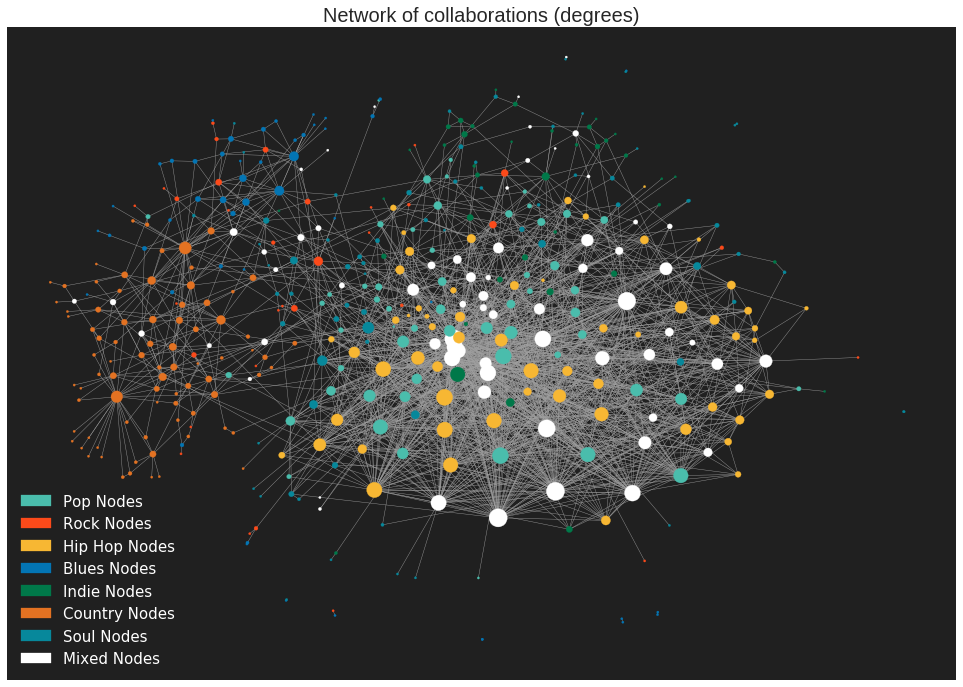

In [29]:
#Visualize the undirected network
drawNetwork("degrees", GU , GU, positions, 'Network of collaborations (degrees)')

With the plot displayed, we can easily see that it exists collaborations with artists of different genres. More concretely, *Hip-hop*, *pop* and *indie* artists tend to be connected between them. While *country* artists tend to collaborate just with artists within his genre. We can also see that there are artists that are just connected by pairs and other ones that are just connected with one other artist. Most of this last mentioned artists are just connected with an artist of their same genre but we can also see some other ones that are connected with an artist of a different genre. Then, in general, we can say that the artists tend to collaborate not just with artists of his same genre, but also with artists that are classified within other ones.

Regarding the degrees of the nodes, the *mixed* artists seem to be the nodes with the higher degree. It means that they have collaborated to more different artists than the other artists. So, it could explain why they are assigned to more than one genre. It is because because, as they tend to collaborate with more artists from different genres, they cannot be assigned in just one.  And, at the same time, they are very well known artists in both genres. The second group with higher degree seems to be the *hip-hop*. On the other side, we can see that there is part of the *blues* artists that tend to be connected by pairs. Finally, as we already analyzed before, no much *rock* artists are displayed because most of the 50% of the *rock* artists nodes are isolated, so its degree is 0.

To obtain a more accurate information related to the degree values of each node of our network created, we will display the three artists per genre that have a higher degree value. 

In [0]:
#Print the top 3 values calculated for each genre
def printResultsTop3(mode, results_dict):
    #print(results_dict)
    for res in results_dict.items():
      gen = res[0]
      resList = res[1]
      print("\nThe top 3 nodes with highest " + mode + " within "+ gen +" artists are:")
      for member in resList[:3]:
        print(G.node[member[0]]['Name'] +": "+str(member[1]))

In [0]:
#Print 3 top members of each party according to the given mode
def printTopMembers(mode,G): 

    #Define empty lists
    results_dict = dict()
    if (mode == "degrees"):
        #Calculate the degree of the nodes
        values = nx.degree(G)
    if (mode == "degreesWeight"):
        #Calculate the degree of the nodes
        values = nx.degree(G, weight='weight')
    if (mode == "betweenness centrality"):
        #Calculate the betweenness centrality of the nodes
        values = nx.betweenness_centrality(G, weight='weight').items()
    if (mode == "eigenvector centrality"):
        #Calculate the eigenvector centrality of the nodes
        values = nx.eigenvector_centrality(G, weight='weight').items()
    if (mode == "closeness centrality"):
        #Set nodes' size proportional to their closeness centrality
        values = nx.closeness_centrality(G).items()

    #Sort the nodes according to he values calculated
    values_res_sort = sorted(values, key=lambda kv: kv[1], reverse=True)
    
    #Separate the all values calculated according to the party of the member 
    for node in values_res_sort:
        artistGenre = genre_dict.get(node[0])
        #print(artistGenre)
        for gen in artistGenre:
          genreResults = results_dict.get(gen)
          if genreResults is None:
            results_dict[gen] = [node]
          else:
            results_dict[gen].append(node)
    printResultsTop3(mode, results_dict)

In [32]:
#Obtain the three nodes with highest degree
printTopMembers("degrees", GU)


The top 3 nodes with highest degrees within pop artists are:
Future: 66
Gucci Mane: 66
Lil Wayne: 65

The top 3 nodes with highest degrees within hip-hop artists are:
Future: 66
Gucci Mane: 66
Lil Wayne: 65

The top 3 nodes with highest degrees within indie artists are:
Wale: 43
G-Eazy: 31
Khalid: 29

The top 3 nodes with highest degrees within country artists are:
Willie Nelson: 30
Colt Ford: 27
Brad Paisley: 16

The top 3 nodes with highest degrees within soul artists are:
John Legend: 26
Mary J. Blige: 20
Alicia Keys: 14

The top 3 nodes with highest degrees within blues artists are:
Eric Clapton: 18
B.B. King: 18
Ray Charles: 11

The top 3 nodes with highest degrees within rock artists are:
Elton John: 16
Fall Out Boy: 11
Imagine Dragons: 10


With the results retrieved, we can see that the top 3 artists, regarding the number of other artists that they have collaborated with, of the *hip-hop* and *pop* artists are the same ones. So we can identify them as three of the *mixed* artists displayed on the network above, as they are classified within more than one genre.

Both three artists - *Future*, *Gucci Mane* and *Lil Wayne* - almost double the number of artists that the other top artists of the other genres have collaborated with. So we can reaffirm that artists within *hip-hop* and *pop* genres seem to be the ones that have collaborated with more different artists. 

After looking for more information related with the three top artists stated, they all three seem to be defined as rapers. It hinds that there is a representation of *hip-hop* artists that are also classified as *pop* artists. It remains to be researched if *Hip-hop* is majorly or solely providing artists to *pop*. A possible correlation with this currency will be also found and exposed during the text analysis of the lyrics.

We can also see with the results retrieved for *rock* and *blues* artists are the ones with less collaborations between the top artists of our created network. It has been interesting to realize that both three top retrieved artists from *blues* genre were all born before the 40's, which can mean, either that currently, this genre is not really popular or that there are no new popular artists within this genre.

Once the number of different artists which with each artist have collaborated has been analyzed, we want to also analyze the number of times that each artist has collaborated with other artists. 

To do it, a second visualization of the graph is displayed below. On it, each node is also colored by genre and the size assigned to the node is the weighted degree of each one.

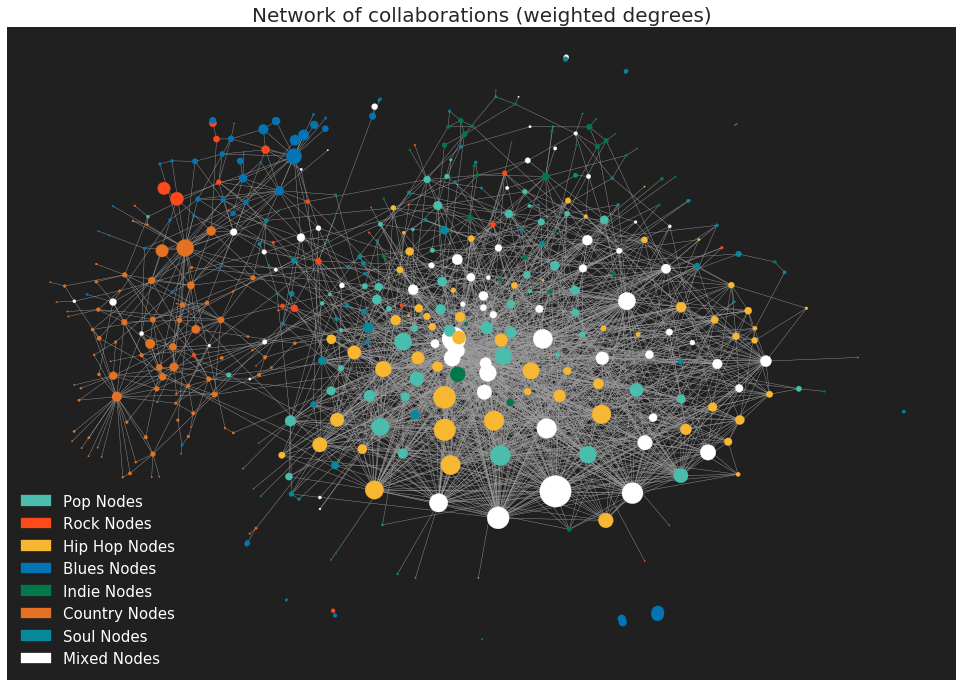

In [33]:
#Visualize the undirected network
drawNetwork("degreesWeigth", GU , GU, positions, 'Network of collaborations (weighted degrees)')

With the plot displayed, we can realize that the relations obtained between nodes are, of course, the same ones. The unique change on the information retrieved is that now the size of the nodes is represented with the weighted degree.  Then, regarding this new measure calculated, we can see that within each genre there are one or a group of few nodes that are considerably bigger respect to the other ones.

It can be clearly seen that there is a big node, which represents an artist within the *mixed* genre. It can reaffirm our previous statements related to that, as this artist tend to collaborate with more artists from different genres, they cannot be assigned in just one. We can also retrieve from the plot shown, that even *blues* artists seemed to do not have collaborated with many other artists, they have collaborated many times with the same ones. It can be specially identified on a pair of connected *blues* artists, that even they are just connected between each other, their calculated weighted average is much higher than many other nodes that have more connections.

To obtain a more accurate information related to the significant weighted degree values of each node of our network created, we will display the three artists per genre that have a higher weighted degree value. 

In [34]:
#Obtain the three nodes with highest degree, eigenvector centrality and betweenness centrality within each party
printTopMembers("degreesWeight", GU)


The top 3 nodes with highest degreesWeight within pop artists are:
Gucci Mane: 494
Lil Wayne: 276
Future: 242

The top 3 nodes with highest degreesWeight within hip-hop artists are:
Gucci Mane: 494
Lil Wayne: 276
Rick Ross: 247

The top 3 nodes with highest degreesWeight within country artists are:
Willie Nelson: 145
Waylon Jennings: 79
George Strait: 47

The top 3 nodes with highest degreesWeight within blues artists are:
Eric Clapton: 118
Janis Joplin: 78
Big Brother & The Holding Company: 78

The top 3 nodes with highest degreesWeight within indie artists are:
Wale: 114
Jeremih: 66
Anderson .Paak: 54

The top 3 nodes with highest degreesWeight within rock artists are:
Tom Petty: 88
Tom Petty and the Heartbreakers: 80
The Rolling Stones: 33

The top 3 nodes with highest degreesWeight within soul artists are:
John Legend: 51
Jamie Foxx: 43
NxWorries: 35


At first glance, the values calculated for the weighted degree are much higher in comparison to the previous ones calculated for the degree.

We can easily recognize the previous bigger node within the *mixed* genre as the *Gucci Mane*. After having a look at his [Wikipedia](https://en.wikipedia.org/wiki/Gucci_Mane) webpage, we can say that Gucci Mane has released more than 12 studio albums, over 70 mixtapes and it was also stated that he has collaborated with many well-known artists, such as Drake, Lil Wayne or Ariana Grande. The three of them are also included in our study and classified within *hip-hop* or *pop* genres

Furthermore, we can also realize that *hip-hop* and *pop* artists are still the artists that have collaborated more times with other artists. But, this time, the order of the values retrieved is not the same as the one obtained before. And, on the other side, *soul* is still the genre where the artists have collaborated fewer times. Finally, we can also realize with numbers that within almost all genres there is one node that has a much higher number of collaborations than the other ones.

Before continuing with the centrality analysis of our network, we would like to calculate the exact number of songs in which the artist has collaborated with other artists. Until now, we had the number of collaborators for each unique songs, but we could not differentiate if one song was created for more than two artists or not. That is why we are showing how the top artists per genre that have collaborated in more number of songs with other artists.

In [35]:
def topArtistByColSongs(mode, artistsSongs):
    #Define empty lists
    results_dict = dict()
    #Sort the nodes according to he values calculated
    values_res_sort = sorted(artistsSongs.items(), key=lambda kv: len(kv[1]), reverse=True)
    #Separate the all values calculated according to the party of the member 
    for node in values_res_sort:
        artistGenre = genre_dict.get(node[0])
        #print(artistGenre)
        for gen in artistGenre:
          genreResults = results_dict.get(gen)
          if genreResults is None:
            results_dict[gen] = [(node[0],len(node[1]))]
          else:
            results_dict[gen].append((node[0],len(node[1])))
    printResultsTop3(mode, results_dict)
topArtistByColSongs("Songs", artistsSongs)


The top 3 nodes with highest Songs within pop artists are:
Gucci Mane: 461
Lil Wayne: 257
Future: 218

The top 3 nodes with highest Songs within hip-hop artists are:
Gucci Mane: 461
Lil Wayne: 257
Rick Ross: 219

The top 3 nodes with highest Songs within country artists are:
Willie Nelson: 141
Waylon Jennings: 78
Colt Ford: 47

The top 3 nodes with highest Songs within blues artists are:
Eric Clapton: 119
Janis Joplin: 78
Big Brother & The Holding Company: 78

The top 3 nodes with highest Songs within indie artists are:
Wale: 102
Jeremih: 63
Anderson .Paak: 52

The top 3 nodes with highest Songs within rock artists are:
Tom Petty: 88
Tom Petty and the Heartbreakers: 80
The Rolling Stones: 33

The top 3 nodes with highest Songs within soul artists are:
John Legend: 51
Jamie Foxx: 39
NxWorries: 35


It can be recognized that the artists retrieved per genre are the same ones than before. This means that most of the artists tend to collaborate in pairs for the different songs created. In fact, for the top *rock* artists the values have not changed, which means that all the songs were in pairs. While the genres that have changed the most are again *pop* and *hip-hop*.

## Centrality analysis

Further analysis on the centrality of the nodes has been done, as we would like to obtain deeper information of the artists of our created network. For each centrality calculated, a visualization network and the top results calculated have been shown.

First, the betweenness centrality of the network has been calculated. Thanks to betweenness centrality algorithm, the most influential nodes in a network can be identified, as it is considered a measure for quantifying the control of an artist on the communication between other artists. We have used the weighted version of the betweenness centrality because we have thought that it would provide more useful information.

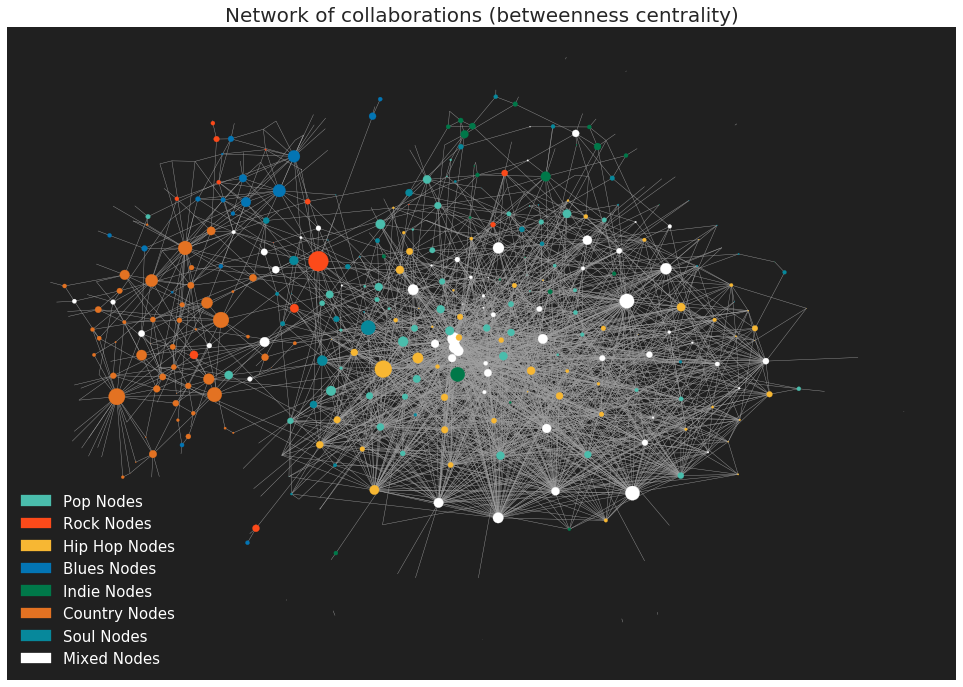

In [36]:
#Visualize the network with nodes' size proportional to their betweenness centrality
drawNetwork("betweenness_centrality", GU , GU, positions, 'Network of collaborations (betweenness centrality)')

With the network plotted, it can be observed that there 
are around seven nodes that seem to be more influential. More concretely, there is a *rock* artist that seems to be the most influential one on the whole network, followed by a *hip-hop* artists, three *country* artists and two *mixed* genre artists. We can also realize that the isolated or low connected nodes have a very small value of betweenness centrality.

To better identify why these artists can be considered as influential ones,  when they do not seem to be the ones with more collaborations, the top artists per genre are displayed.


In [37]:
#Obtain the three nodes with highest degree, degree weigth, eigenvector centrality and betweenness centrality within each party
printTopMembers("betweenness centrality", GU)


The top 3 nodes with highest betweenness centrality within rock artists are:
Elton John: 0.05618034419817423
Florida Georgia Line: 0.013080983440806576
Paul McCartney: 0.010380730966670597

The top 3 nodes with highest betweenness centrality within hip-hop artists are:
Snoop Dogg: 0.04076877180464798
Ty Dolla $ign: 0.029793111534182386
Young Thug: 0.02892391115578903

The top 3 nodes with highest betweenness centrality within country artists are:
Colt Ford: 0.03817686159094518
Brad Paisley: 0.03524748743887196
Darius Rucker: 0.029852050915596482

The top 3 nodes with highest betweenness centrality within pop artists are:
Ty Dolla $ign: 0.029793111534182386
Young Thug: 0.02892391115578903
Lil Wayne: 0.023014944682621826

The top 3 nodes with highest betweenness centrality within soul artists are:
John Legend: 0.02922199586192181
Mary J. Blige: 0.014668398781684187
Anthony Hamilton: 0.011280088545491333

The top 3 nodes with highest betweenness centrality within indie artists are:
Wale:

The most influential node of the network is *Elton John*. His betweenness centrality value is high because it is the node that is helping to connect more other nodes at their shortest path. It is followed by *Snoop Dogg*, *country* artist. 

So we can see that even they are not artists that have a lot of numbers of collaborations and connections on the node, they are considered the most influential artists of the network. So, if we would be artists, maybe it could be a good idea to think on them to do our next collaboration if we want to arrive to more public.

Afterwards, the closeness centrality has been calculated. Thanks to closeness centrality we are able to measure of centrality of a node in the network.

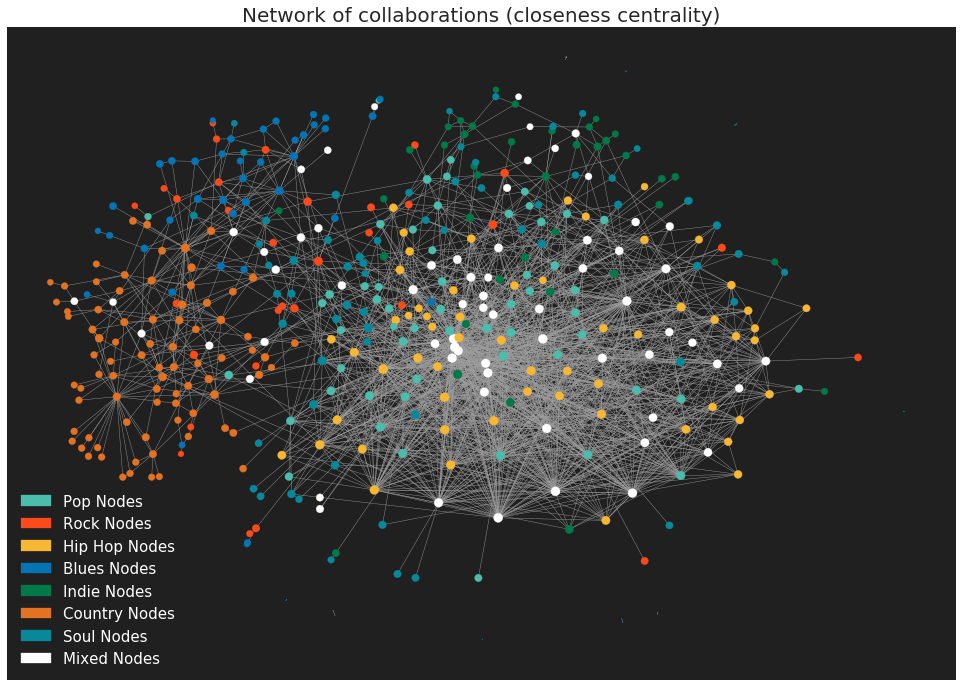

In [38]:
#Visualize the network with nodes' size proportional to their closeness centrality
drawNetwork("closeness_centrality", GU , GU, positions, 'Network of collaborations (closeness centrality)')

In [39]:
#Obtain the three nodes with highest degree, degree weigth, eigenvector centrality and betweenness centrality within each party
printTopMembers("closeness centrality", GU)


The top 3 nodes with highest closeness centrality within hip-hop artists are:
Snoop Dogg: 0.2852831539448998
Lil Wayne: 0.2808050250279438
Future: 0.2747171112061998

The top 3 nodes with highest closeness centrality within pop artists are:
Lil Wayne: 0.2808050250279438
Future: 0.2747171112061998
Gucci Mane: 0.27225769212646656

The top 3 nodes with highest closeness centrality within indie artists are:
Miguel: 0.2608163311365893
Wale: 0.2583787953315745
Jeremih: 0.2500919754155125

The top 3 nodes with highest closeness centrality within soul artists are:
John Legend: 0.2549135306833723
Mary J. Blige: 0.24886402790938064
Jamie Foxx: 0.24002513189049973

The top 3 nodes with highest closeness centrality within rock artists are:
Elton John: 0.24624440656296612
Fall Out Boy: 0.2328574594986701
U2: 0.22848372810312784

The top 3 nodes with highest closeness centrality within country artists are:
Willie Nelson: 0.24505386148691632
Darius Rucker: 0.23003921490564536
Carrie Underwood: 0.224

As we can see with the results retrieved, all connected nodes have a similar closeness centrality, while the other ones have a low value. It is a normal case because our created network is an undirected graph with quite a lot of connections between most of the nodes. But, then, we consider that we cannot obtain any conclusion using this kind of centrality. 

Finally, the eigenvector centrality has been calculated. Thanks to eigenvector centrality algorithm, the nodes that are connected to other influential nodes can be identified, as it gives a high score to nodes that are connected to many nodes who also have high scores.

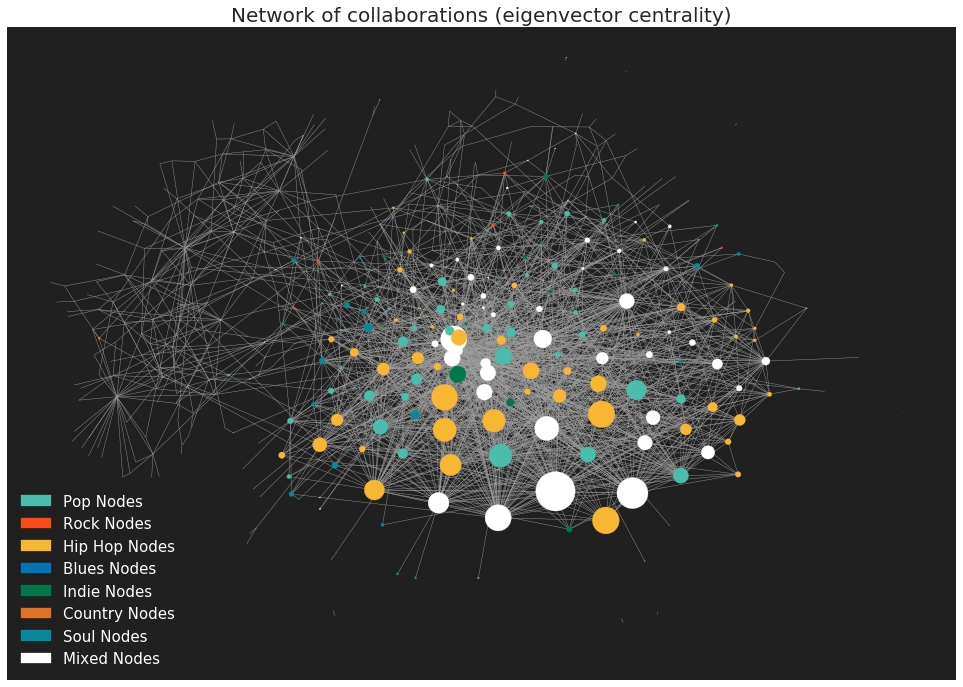

In [40]:
 #Visualize the network with nodes' size proportional to their eigenvector centrality
drawNetwork("eigenvector_centrality", GU , GU, positions, 'Network of collaborations (eigenvector centrality)')

With the network plotted, it can be observed that the nodes with higher eigenvector centrality are artists from *mixed*, *hip-hop* and *pop* genres. In fact, the artists of the *mixed* genre seem to have a slightly higher value calculated. So we can say that artists of these genres tend to do more collaborations than the other ones.

To better identify the artists considered as more influential, the top artists per genre are displayed.


In [41]:
printTopMembers("eigenvector centrality", GU)


The top 3 nodes with highest eigenvector centrality within pop artists are:
Gucci Mane: 0.5156893387255662
Young Thug: 0.3201795062872812
Lil Wayne: 0.22838254430120813

The top 3 nodes with highest eigenvector centrality within hip-hop artists are:
Gucci Mane: 0.5156893387255662
Young Thug: 0.3201795062872812
Young Dolph: 0.2401158774118845

The top 3 nodes with highest eigenvector centrality within indie artists are:
Wale: 0.09084269529100443
Jeremih: 0.033723988264909306
PARTYNEXTDOOR: 0.01936948369484586

The top 3 nodes with highest eigenvector centrality within soul artists are:
Jamie Foxx: 0.025572289961650584
John Legend: 0.024778291233953458
Kelly Rowland: 0.012692649366362413

The top 3 nodes with highest eigenvector centrality within rock artists are:
Fall Out Boy: 0.004147820556644076
X Ambassadors: 0.002984705370919689
Imagine Dragons: 0.002843585394483746

The top 3 nodes with highest eigenvector centrality within country artists are:
Brantley Gilbert: 0.0015999170190024

With the results retrieved, we can identify *Gucci Mane* as the most collaborative artist of our network. We can also appreciate that *pop* and *hip-hop* artists are in general the most collaborative artists of the network. And, on the other side, *blues* artists are the less collaborative ones. So, once again, it seems that *pop* and *hip-hop* tend to do more collaborations than artists from other genres.

Now, we would like to check which is the genre that tends to have more artists that collaborated with other ones. To achieve it, we are displaying the real distribution of collaborations between the artists of our network and calculating the total number of collaborations per genre.

In [0]:
#Calculate the strength degree distribution for each genre (sum of the weight of links)
def calculateDegreeDistribution(GU): 
    degreeDistDict = dict()
    nodes = nx.degree(GU, weight='weight')
    for node in nodes:
      artistGenre = genre_dict.get(node[0])
      for gen in artistGenre:
        genreResults = degreeDistDict.get(gen)
        if genreResults is None:
          degreeDistDict[gen] = [node[1]]
        else:
          degreeDistDict[gen].append(node[1])
    return degreeDistDict

In [0]:
#Plot the outgoing strength distribution of each party (sum of the weight on outgoing links)
def showPlot(degreeDistDict):  
    plt.figure(3,figsize=(20,10))
    #Set backgroud color
    plt.rcParams['axes.facecolor'] = "#FFFFFF"
    colors = ["#4abdac", "#f7b733", "#007849", "#07889b", "#fc4a1a", "#0375b4", "#e37222"]
    #Bin the degree distribution
    count = 0
    for outgoing in degreeDistDict.items():
      #x = list(nx.degree(G).values())
      if(outgoing[0] == 'pop'):
        pop_patch = mpatches.Patch(color='#4abdac', label='Pop Nodes', facecolor = 'white')
      elif (outgoing[0] == 'rock'):
        rock_patch = mpatches.Patch(color='#fc4a1a', label='Rock Nodes')
      elif(outgoing[0] == 'hip-hop'):
        hip_hop_patch = mpatches.Patch(color='#f7b733', label='Hip Hop Nodes')
      elif(outgoing[0] == 'blues'):
        blues_patch = mpatches.Patch(color='#0375b4', label='Blues Nodes')
      elif(outgoing[0] == 'indie'):
        indie_patch = mpatches.Patch(color='#007849', label='Indie Nodes')
      elif(outgoing[0] == 'country'):
        country_patch = mpatches.Patch(color='#e37222', label='Country Nodes')
      elif(outgoing[0] == 'soul'):
        soul_patch = mpatches.Patch(color='#07889b', label='Soul Nodes')
      histoDem, bin_edgesDem = np.histogram(outgoing[1])
      #histoDem, bin_edgesDem = np.histogram(outgoing, bins=range(max(outgoing)))
      histoDem = np.append(histoDem,0)
      plt.plot(bin_edgesDem,histoDem, color=colors[count])
      count += 1
    #Plot bar chart
    plt.ylabel('# of collaborations')
    plt.title('Weighted degree distribution per genre')
    leg = plt.legend(handles=[pop_patch, rock_patch, hip_hop_patch, blues_patch, indie_patch, country_patch, soul_patch], fontsize = 15)
    #for text in leg.get_texts():
    #    plt.setp(text, color = 'b')
    plt.show()
    plt.show()

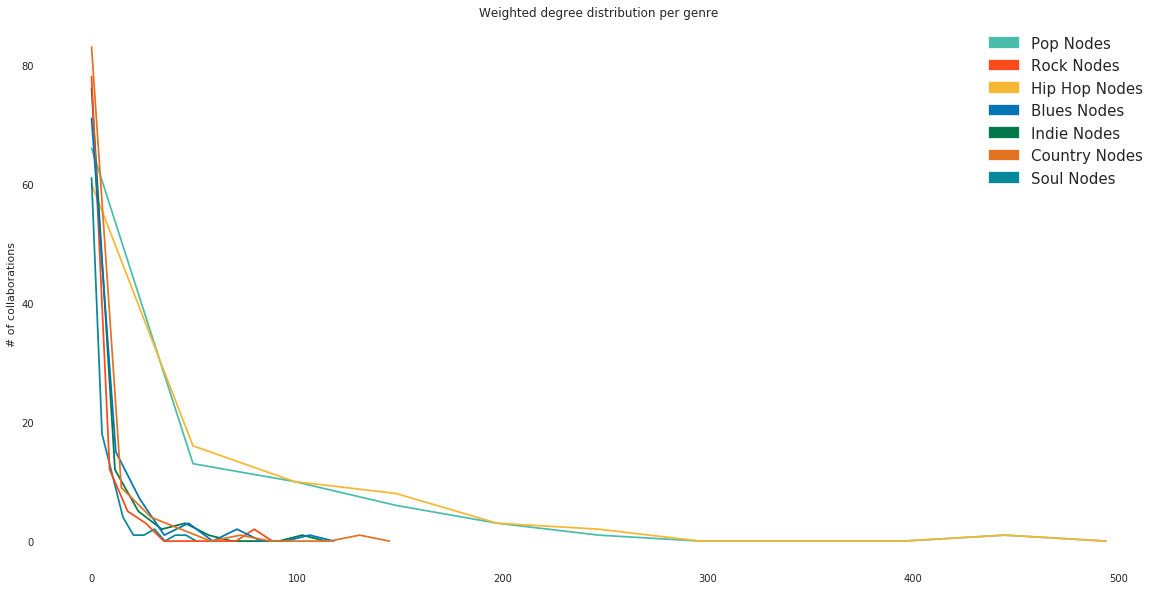

In [44]:
#Plot the distribution of outgoing strength for the republican and democratic nodes
degreeDistDict = calculateDegreeDistribution(GU)
showPlot(degreeDistDict)

In [0]:
#Calculate the outgoing strength distribution for each party (sum of the weight on outgoing links)
def calculateTotalNumberOfColabsPerGenre(G):
    outgoingDistDict = dict()
    nodes = nx.degree(G, weight='weight')
    for node in nodes:
      artistGenre = genre_dict.get(node[0])
      for gen in artistGenre:
        genreResults = outgoingDistDict.get(gen)
        if genreResults is None:
          outgoingDistDict[gen] = node[1]
        else:
          outgoingDistDict[gen] += node[1]
    return outgoingDistDict

In [0]:
#Print the top 3 values calculated for each party
def printResultsColabs(results_dict):
    results_dict = sorted(results_dict.items(), key=lambda kv: -kv[1])
    for res in results_dict:
      print("\nThe total number of collaboration for the artists within "+ res[0] +" is:", res[1])

In [47]:
outgoingDistDict = calculateTotalNumberOfColabsPerGenre(GU)
printResultsColabs(outgoingDistDict)


The total number of collaboration for the artists within hip-hop is: 6676

The total number of collaboration for the artists within pop is: 5896

The total number of collaboration for the artists within blues is: 1049

The total number of collaboration for the artists within country is: 964

The total number of collaboration for the artists within indie is: 913

The total number of collaboration for the artists within soul is: 658

The total number of collaboration for the artists within rock is: 589


With the plot and information displayed, we can confirm that *hip-hop* and *pop* artists are the ones that have collaborated more times with other artists. And, on the other side, there are *soul* and *rock*.

## Communities detection


At this point, we would like to see if artists of one same genre, tend to collaborate with artists of the same genre or to different ones. To do it, we are finding the different communities in our network and we will see if exists a correlation with the genres assigned to each node. 

Communities are considered groups of vertices that have a higher probability of being connected to each other, than to members of other groups. Then, we can say that communities tend to join pairs of nodes that are more likely to be connected. In our case, to calculate the communities of our network, the Louvain best partition algorithm has been used and its modularity has been calculated.


In [0]:
#Compute the communities of a graph using best partition
def computeCommunities(G_und):
    #first compute the best partition
    partition = community_louvain.best_partition(G_und)
    return partition
#Calculate the modularity of the algorithm
def calculateModularity(partition, G_und):
    modularity = community_louvain.modularity(partition, G_und)
    return modularity

In [49]:
#Find communities in the full house of representatives network
partition = computeCommunities(GU)
#Calculate the modularity found by the previous algorithm
modularity = calculateModularity(partition, GU)
print("\nThe modularity calculated is: " + str(round(modularity,4)))


The modularity calculated is: 0.5131


The modularity measures the strength of the communities defined of our network, by dividing groups of nodes with dense connections between members of the same groups and sparser connections between members of other groups. As the modularity calculated in our case is *0.51*, we can assume that the partitions found are quite good but it maybe has had problems on detecting the small communities as there are quite a lot of isolated nodes.

The best way to show the communities detected is displaying them on a graph using again the Networkx draw function.

In [0]:
#Visualize the network of communities of all top artists
def drawNetworkCommunities(G_und,positions, partition,title):
    #Define figure size
    plt.figure(3,figsize=(15,15))
    plt.title(title, fontsize=20)
    #Set backgroud color
    #plt.rcParams['axes.facecolor'] = "#FFFFFF"
    # Hide grid lines
    plt.grid(False)
    # Hide axes ticks
    plt.xticks([])
    plt.yticks([])
    #Obtain list of nodes of the graph
    nodes = partition.keys()
    edges = G_und.edges
    
    #Calculate node colors according to community assigned
    colors= list(partition.values())
    #Plot created network
    nx.draw_networkx(G_und, positions, nodelist=nodes, edgelist=edges,cmap=plt.get_cmap('gist_ncar'), width=0.4, with_labels=False, node_size=50, node_color=colors,edge_color='grey')
    plt.show()

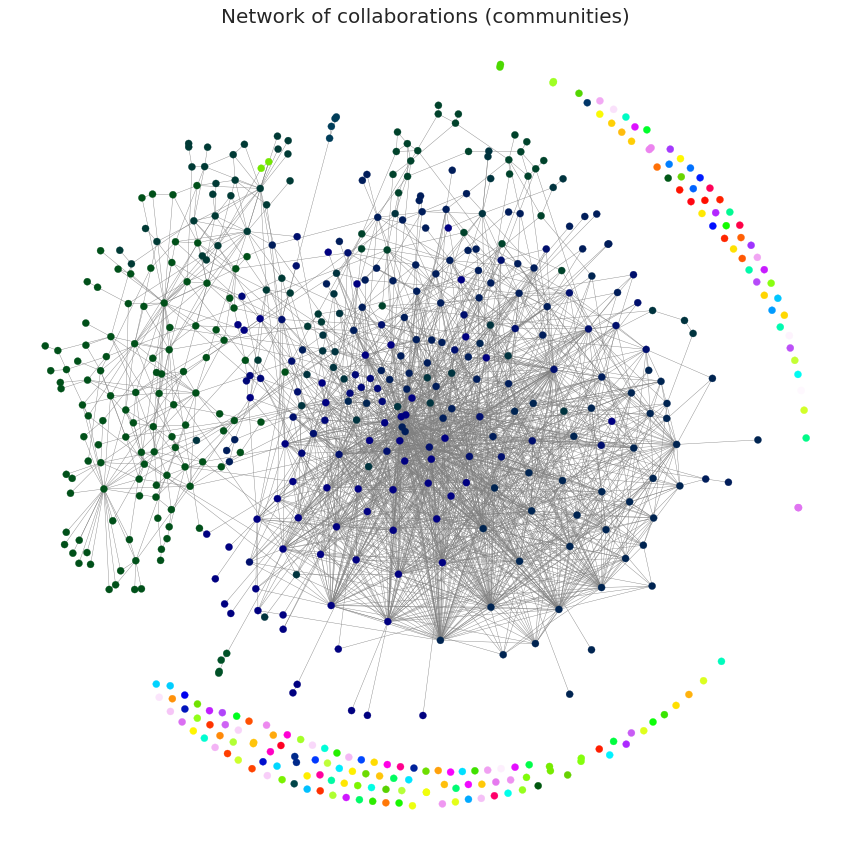

In [64]:
#Visualize the network with nodes' colors based on their community
drawNetworkCommunities(GU,positions, partition, 'Network of collaborations (communities)')

A confusion matrix has also been created to obtain a better comparation between the comunities created and the genres assigned for each artist.

In [0]:
#Compute the confusion matrix of the genres and communities of the network
def computeConfusionMatrix(G, partition):
    #Define the dimension of the D matrix
    confusion_matrix = np.zeros((7, len(set(partition.values()))))
    #Calculate the values of the D matrix defined
    for part in partition.items():
        #Check the genre of the node
        for gen in genre_dict[part[0]]:
          count = 0
          for g in genres:
            if (g==gen):
              confusion_matrix[count][part[1]] += 1
            count +=1
    return confusion_matrix

In [0]:
# Display confusion matrix using seaborn
def plotConfusionMatrix(confusion_matrix):
  fig, ax = plt.subplots(figsize=(25,5)) 
  df_cm = pd.DataFrame(confusion_matrix[:,1:20])
  sn.heatmap(df_cm, ax=ax, annot=True, annot_kws={"size": 12})
  reverse_genres = genres[::-1]
  ax.set_yticklabels(reverse_genres)

The number of communities created is  181


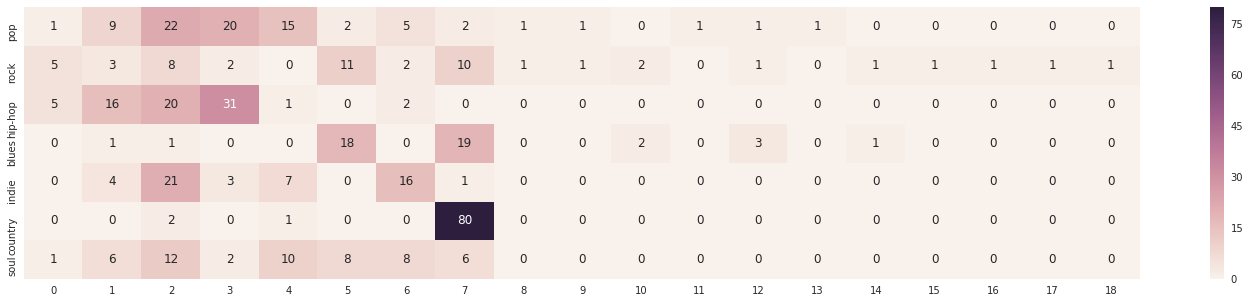

In [54]:
# Calculate number of communities created
print("The number of communities created is ", len(set(partition.values())))
#Obtain the confusion matrix of the network of collaborations
confusion_matrix = computeConfusionMatrix(GU, partition)
plotConfusionMatrix(confusion_matrix)

With both, the visualization of the graph and the confusion matrix displayed, we can observe that 181 different communities have been created to define our network. Unfortunately, 167 of this communities only hold a unique artist, which means that all isolated nodes and a few more have been related to any other similar node.

To provide a better visualization of the results of the confusion matrix, just the first 18 communities have been displayed. With the results provided, it can be seen that almost all *country* artists are contained within the same community. This is because, as we previously visualized, almost all *country* artists are connected between them because they tend to have collaborations between them. On the other side, *rock* artists are distributed in many different communities, as most of their artists do not have collaborations with other artists.

From the information retrieved, it can be also realized that there are three partitions - 2, 3 and 7 - that relationate quite a huge amount of nodes. These main partitions contain artists from almost all genres, which can mean that there are quite a lot of artists that tend to collaborate with artists that are classified in other genres. And finally, we can see that there are two partitions - 0 and 7 - that are mainly formed from artists of *pop* and *hip-hop* genres. This reaffirms again that there is a significant link between the *pop* and *hip-hop* genres.

## Friendship Paradox

We would also like to check if the friendship paradox is accomplished on our created network. To do it, we have calculated the number of times that the weight of the degree of the neighbor nodes of a node is bigger than their own calculated value.

In [0]:
#Calculate friendship paradox
def friendshipParadox(G, weightedTrue=False):
  count = 0
  degrees = nx.degree(G, weight='weight')
  for node in degrees:
      neigh = [n for n in nx.neighbors(G, node[0])]
      if(weightedTrue):
        neighDe = G.degree(neigh, weight='weight')
      else:
        neighDe = G.degree(neigh)
      values = [x[1] for x in neighDe]
      if (len(values)>1):
          neighmean = np.mean(values)
      elif (len(values)==1):
          neighmean = values[0]
      else:
          neighmean=0
      if node[1] < neighmean:
          count+=1 
  #     print "Num of node: ", nodDe, "- Avg. of its neighbors:", neighmean
  print("Friendship paradox has been true", round((count/len(degrees))*100,2) ,"% of the times")

In [56]:
friendshipParadox(GU, True)

Friendship paradox has been true 61.08 % of the times


With the result retrieved, we can see that the affirmation stated before has been accomplished the *61.8%* of the times on the nodes of our networks.

## Assortativity

Now, the coefficient of assortativity of our network has been calculated. Assortativity is considered the preference for the network's nodes to attach to others that are similar in some way. In our case, we have used the *degree assortativity coefficient* function of networkx to calculate the assortativity of our graph. This function measures the similarity of connections in the graph with respect to the node degree. So, we have decided to calculate this coefficient to see if the artists of our network tend to collaborate with other artists that have a similar number of collaborations' artists.




In [57]:
#Compute degree assortativity
nx.degree_assortativity_coefficient(GU)

0.2833011374443291

The coefficient of assortativity calculated for our network is 0.28. As the calculated value is more close to 0 than 1, we have to say that our network tends to be non-assortative. This means that the artists of our network do not tend to collaborate with other artists that have collaborated with a similar number of artists.

## Cliques analysis

Finally, we have evaluated the information provided by the cliques to try to find similar artists from their collaboration information. The hypothesis that we are trying to implement here is:

 > *"There is a huge probability that I like artists that have collaborated with my favorite artist"*

Or even more,

 > *"There is a huge probability that I like artists that are completely connected with artists that are completely connected with my favorite artist"*

Due to the fact that a clique is defined as a subset of vertices of an undirected graph such that they form a completed subgraph, we would like to use this information to create a small recommendation system with the information retrieved from the calculated cliques of the network.

Before doing that we have retrieved some useful information regarding the cliques of our network. More concretely, the number of different cliques of our network has been calculated in addition to the number of artists that form the largest clique.


In [58]:
#Calculate number of cliques
cliques = nx.graph_number_of_cliques(GU)
print("The number of different cliques calculated for the whole network is", cliques)
#Calculate the number of artists that form the largest clique of the network
value = nx.graph_clique_number(GU)
print("The number of artists that form the largest clique of the network is", value)

The number of different cliques calculated for the whole network is 2090
The number of artists that form the largest clique of the network is 12


Then, we have found all cliques and we have displayed a graph for one of the calculated cliques.

In [0]:
#Calculate node colors according to the given mode
def calculateColorsOfNodes(mode,G,nodes):
  colors = []
  if(mode == "full_graph"):
    #Set node colors according to their party (blue for democratic and red for republicans)
    for n in nodes:
      ['pop','hip-hop']
      if (genre_dict[n] == ['pop']):
        pop_patch = mpatches.Patch(color='#4abdac', label='Pop Nodes', facecolor = 'white')
        colors.append("#4abdac")#fresh green
      elif(genre_dict[n] == ['hip-hop']):
        hip_hop_patch = mpatches.Patch(color='#f7b733', label='Hip Hop Nodes')
        colors.append("#f7b733")#sunshine
      else:
        mixt_patch = mpatches.Patch(color='grey', label='Mixed Nodes')
        colors.append("grey")#teal blue
    leg = plt.legend(handles=[pop_patch,hip_hop_patch, mixt_patch], fontsize = 15)
    for text in leg.get_texts():
        plt.setp(text, color = 'black', size=8)
  return colors

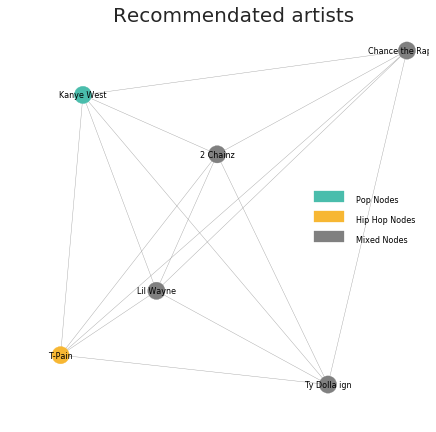

In [69]:
#Calculate cliques of our network
cliques = nx.find_cliques(GU)
cliques = [clq for clq in cliques if len(clq)]
#Plot a clique calculated
nodes = cliques[3]
h = GU.subgraph(nodes)

plt.figure(3,figsize=(7,7))
#Set backgroud color
plt.rcParams['axes.facecolor'] = "#202020"
forceatlas2 = setForceAtlasParameters()
positions = calculateCoordinatesUsingForceAtlas(h,forceatlas2)
nodes = nx.nodes(h)
colors = calculateColorsOfNodes("full_graph", h, nodes)
plt.title("Recommendated artists", fontsize=20)
plt.rcParams['font.family'] = 'Verdana'
#Obtain list of nodes of the graph
nodes = nx.nodes(h)
cliques_names = {k:v for k, v in names_dict.items() if k in h}
nx.draw(h,labels=cliques_names, with_labels = True, node_color=colors, font_size=8, font_family='Verdana', width=0.4, edge_color="#a0a0a0")
plt.show()

With the plot displayed, we can see that all nodes are fully connected which converts the subgraph in a complete one. 

Taking into account these strong connections between nodes, we would like to create the basis for a recommendation system of artists.

Our first approach to achieve it is to retrieve all artists that appear in any clique calculated for a specific artist. After this line, we are showing the results obtained for the artist "Ed Sheran".

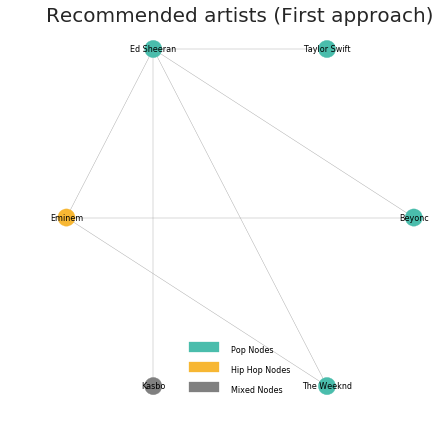

In [70]:
def recommendArtists(artist='6eUKZXaKkcviH0Ku9w2n3V'):
  cliques = nx.cliques_containing_node(GU,[artist])
  for item in cliques.items():
    result = set(x for l in item[1] for x in l)
    for res in result:
      cliques = nx.cliques_containing_node(GU,res)
    h = GU.subgraph(result)
    cliques_names = {k:v for k, v in names_dict.items() if k in h}
    forceatlas2 = setForceAtlasParameters()
    positions = calculateCoordinatesUsingForceAtlas(h,forceatlas2)

    plt.figure(3,figsize=(7,7))
    #Set backgroud color
    plt.rcParams['axes.facecolor'] = "#202020"
    plt.title("Recommended artists (First approach)", fontsize=20)
    plt.rcParams['font.family'] = 'Verdana'
    nodes = nx.nodes(h)
    colors = calculateColorsOfNodes("full_graph", h, nodes)
    #Obtain list of nodes of the graph
    nodes = nx.nodes(h)
    cliques_names = {k:v for k, v in names_dict.items() if k in h}
    nx.draw_circular(h, nodelist=nodes, node_color=colors, font_size=8, font_family='Verdana', labels=cliques_names, with_labels = True,cmap=plt.get_cmap('jet'), width=0.4, edge_color="#a0a0a0")
    plt.show()
    
recommendArtists('6eUKZXaKkcviH0Ku9w2n3V')

With the new subgraph displayed, were all artists that appear in at least one clique of the artist Ed Sheeran are included, we can see that all nodes retrieved are the neighbors of the artist Ed Sheeran. In his case are just 5, and not all are classified within his same genre.

That is why we have created a second approach for our recommendation system. This time we will also include the artists that appear in one clique of the neighbors of the first artist proposed.

In [0]:
#Calculate node colors according to the given mode
def calculateColorsOfNodes(mode,G,nodes):
  colors = []
  if(mode == "full_graph"):
    #Set node colors according to their party (blue for democratic and red for republicans)
    for n in nodes:
      ['pop','rock','hip-hop','blues','indie','country','soul']
      if (genre_dict[n] == ['pop']):
        pop_patch = mpatches.Patch(color='#4abdac', label='Pop Nodes', facecolor = 'white')
        colors.append("#4abdac")#fresh green
      elif(genre_dict[n] == ['rock']):
        rock_patch = mpatches.Patch(color='#fc4a1a', label='Rock Nodes')
        colors.append("#fc4a1a")#vermillion red
      elif(genre_dict[n] == ['hip-hop']):
        hip_hop_patch = mpatches.Patch(color='#f7b733', label='Hip Hop Nodes')
        colors.append("#f7b733")#sunshine
      elif(genre_dict[n] == ['blues']):
        blues_patch = mpatches.Patch(color='#0375b4', label='Blues Nodes')
        colors.append("#0375b4")#starry night blue
      elif(genre_dict[n] == ['indie']):
        indie_patch = mpatches.Patch(color='#007849', label='Indie Nodes')
        colors.append("#007849")#irises green
      elif(genre_dict[n] == ['country']):
        country_patch = mpatches.Patch(color='#e37222', label='Country Nodes')
        colors.append("#e37222")#country tangerine
      elif(genre_dict[n] == ['soul']):
        soul_patch = mpatches.Patch(color='#07889b', label='Soul Nodes')
        colors.append("#07889b")#teal blue
      else:
        mixt_patch = mpatches.Patch(color='grey', label='Mixed Nodes')
        colors.append("grey")#teal blue
    leg = plt.legend(handles=[pop_patch, rock_patch, hip_hop_patch, indie_patch, country_patch, soul_patch, mixt_patch], fontsize = 15)
    for text in leg.get_texts():
        plt.setp(text, color = 'black', size=8)
  return colors

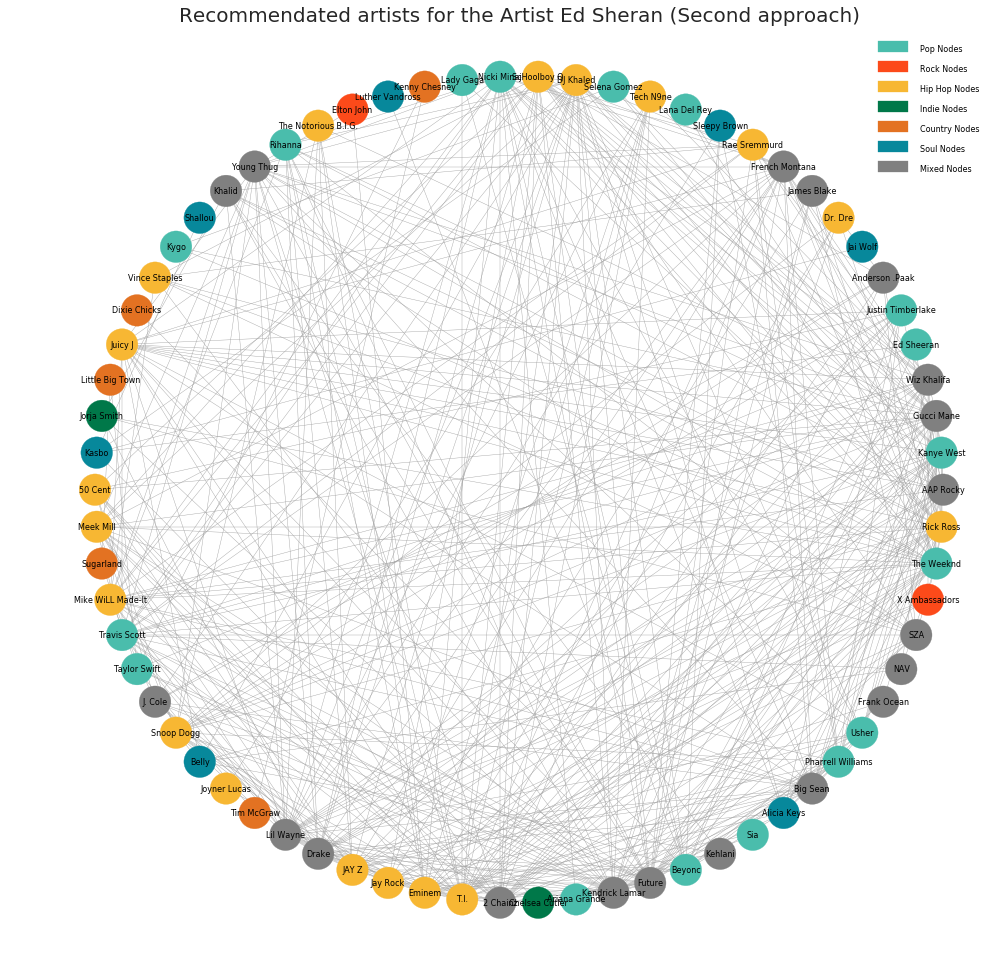

In [72]:
def recommendArtistsFromArtist(artist='6eUKZXaKkcviH0Ku9w2n3V'):
  allnodes = list()
  cliques = nx.cliques_containing_node(GU,[artist])
  for item in cliques.items():
    result = set(x for l in item[1] for x in l)
    allnodes.append(result)
    for res in result:
      cliques1 = nx.cliques_containing_node(GU,[res])
      for item in cliques1.items():
        result1 = set(x for l in item[1] for x in l)
        allnodes.append(result1)
    allnodes = set(x for l in allnodes for x in l)
    h = GU.subgraph(allnodes)
    cliques_names = {k:v for k, v in names_dict.items() if k in h}

    plt.figure(3,figsize=(17,17))
    #Set backgroud color
    plt.rcParams['axes.facecolor'] = "#202020"
    forceatlas2 = setForceAtlasParameters()
    positions = calculateCoordinatesUsingForceAtlas(h,forceatlas2)
    nodes = nx.nodes(h)
    colors = calculateColorsOfNodes("full_graph", h, nodes)
    plt.title("Recommendated artists for the Artist Ed Sheran (Second approach)", fontsize=20)
    #Obtain list of nodes of the graph
    plt.rcParams['axes.facecolor'] = "#202020"
    plt.rcParams['font.family'] = 'Verdana'
    nx.draw_circular(h, nodelist=nodes, node_size=1000, font_size=8, font_family='Verdana', labels=cliques_names, node_color=colors, with_labels = True,cmap=plt.get_cmap('jet'), width=0.4, edge_color="#a0a0a0")
    plt.show()

recommendArtistsFromArtist()

The given graph shows that now 70 other artists are recommended by the artist Ed Sheran. This is because Ed Sheran has not collaborated with many other artists but the artists that he has collaborated with are artists with a considerable number of collaborations. We can also realize, this way, that artists tend to collaborate with artists of other genres too.

More accurate approaches, just taking cliques of a specific number of nodes, could be developed as a further work.

# Conclusions

* What we have done right. After finishing the analysis of the network of collaborations, we think that we have represented correctly the information of the collaboration between artists on the network created. We struggled a little bit at the begining to really understand the format and structure of the information retrieved on the services of the Spotify API, because it was not really clear with the information provided on their services. That is why we have included the whole analysis done on the creation of our network, even our first approach was not the correct one. But thanks to our exhaustive analysis on the format and data obtained on the first directed graph created, we have been able to create a new approach with the data well preprocessed. Thanks to this second approach with an undirected graph, we have been able to easily analyze the collaborations done between the different artists and we have applied convenient tools and techniques learnt during the course to extract useful information from the data. We are specially proud to have been able to create the basis for a recommendation system.

* What we have not done. First of all, we think that we could have visualized some results in a more user-friendly way. Specially, the information retrieved from some functions as outputs on the Jupyter notebook. Furthermore, we think that we could have tried to create a function that show the basis of the recommended system for more artists on the website. But, unfortunately we have not have more time to do it. In addition, we think that our same analysis should have done with a higher dataset, with more artists and more genres in order to extract more information from it. And, finally, we could also download data from other well-known streaming services (e.g. SoundCloud or Youtube) to see if the results obtained are similar ones or not.